In [12]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from decision_diffuser import DecisionDiffuserTrainConfig
from janner_diffuser import JannerDiffuserTrainConfig
from decision_diffuser import eval_model as dd_eval
from janner_diffuser import eval_model as janner_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import make_envs_and_datasets_gridland, GridLand
import matplotlib.pyplot as plt
env = 'gridland'
n_size = 10
memory = 1
horizon = 512
num_envs = 1
num_episodes = 1
temperature = 0.5
n_exec_steps = 500
render = True

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Avg. Completion: 0.0


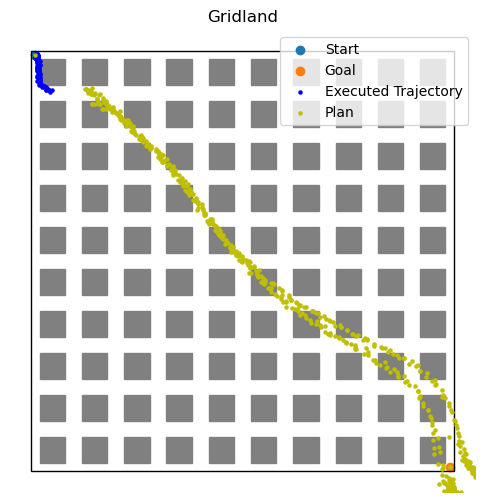

In [28]:
### eval for diffuser w/inpainting

# loads config, modifies to work w/given parameters
config = JannerDiffuserTrainConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True

# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
#invdyn.load(config.invdyn_path)
invdyn.eval()

# loads agent 
# --------------- Network Architecture -----------------# 
nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=False, kernel_size=5)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)
agent.load('trained_models/JannerInpaint-gridland-n10.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset()
avg_completion,trajectories, replans = janner_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)

print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset()
fig, ax = env.get_mpl_plot()

#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='b',s=5,label='Executed Trajectory')
ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
ax.legend()

In [27]:
print(trajectories[0].shape)
print(replans[0].shape)


(201, 1, 2)
(1, 512, 2)
